,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-09,2096.560059,2096.560059,2068.239990,2078.580078,2078.580078,3882350000
1,2015-11-10,2077.189941,2083.669922,2069.909912,2081.719971,2081.719971,3821440000
2,2015-11-11,2083.409912,2086.939941,2074.850098,2075.000000,2075.000000,3692410000
3,2015-11-12,2072.290039,2072.290039,2045.660034,2045.969971,2045.969971,4016370000
4,2015-11-13,2044.640015,2044.640015,2022.020020,2023.040039,2023.040039,4278750000


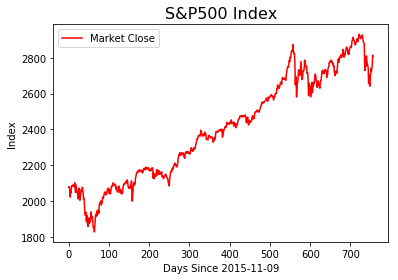

In [146]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import talib as ta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from pandas import concat

# Load the SP500 index dataset
data = pd.read_csv("SP500-index.csv")

# Display the first record
display(data.head(n=5))

#Plot the close of recent 3 years' S&P500
plt.plot(data['Close'],color='r',label='Market Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Index')
plt.title('S&P500 Index', fontsize=16)
plt.show()


In [147]:
# Some statistics
print('The miminum index: %.2f' % np.amin(data['Close']))
print('The maximum index: %.2f' % np.amax(data['Close']))

The miminum index: 1829.08
The maximum index: 2930.75


In [148]:
data_persistence1 = data[['Close']]
display(data_persistence1.head())

,Close
0,2078.580078
1,2081.719971
2,2075.000000
3,2045.969971
4,2023.040039


In [149]:
data_persistence2 = concat([data_persistence1['Close'].shift(1), data_persistence1['Close']], axis = 1)
data_persistence2.columns = ['Close Shift', 'Close']
display(data_persistence2.head())

,Close Shift,Close
0,NaN,2078.580078
1,2078.580078,2081.719971
2,2081.719971,2075.000000
3,2075.000000,2045.969971
4,2045.969971,2023.040039


In [150]:
data_persistence3 = data_persistence2.dropna()
display(data_persistence3.head())


,Close Shift,Close
1,2078.580078,2081.719971
2,2081.719971,2075.000000
3,2075.000000,2045.969971
4,2045.969971,2023.040039
5,2023.040039,2053.189941


In [151]:
ss1 =StandardScaler()
data_persistence4 = data_persistence3
data_persistence3.iloc[:,:]=ss1.fit_transform(data_persistence3.iloc[:,:])


/Users/yuyuanlin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/yuyuanlin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [152]:
# split into train and test sets
X = data_persistence3.values
train_size = int(0.9*len(X))
train = X[:train_size]
test = X[train_size:]
X_train = train[:,0]
y_train = train[:,1]
X_test = test[:,0]
y_test = test[:,1]


In [153]:
# persistence model, essentially this model does not do anything
def model_persistence(x):
    return x


In [154]:
pred_persistence = np.apply_along_axis(model_persistence, 0, X_test)
# Calcualte the MSE
MSE_persistence = mean_squared_error(y_test, pred_persistence)
print('Test MSE of persistence algorithm: %.4f' % MSE_persistence)

Test MSE of persistence algorithm: 0.0074


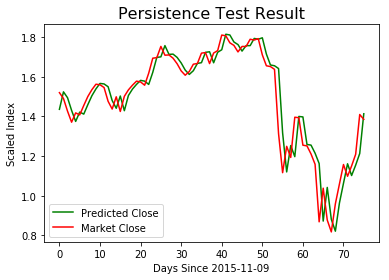

In [155]:
plt.plot(pred_persistence, color='g',label='Predicted Close')
plt.plot(y_test,color='r',label='Market Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('Persistence Test Result', fontsize=16)
plt.show()

In [156]:
# Below is the implementation of SVM regression algorithm

In [157]:
# drop the Adj Close
data_SVR=data[['Open','High','Low','Close','Volume']]

# Shift the data by 1-day so the prediction is based on the information available 1-day before
data_SVR['open'] = data_SVR['Open'].shift(1)
data_SVR['high']=data_SVR['High'].shift(1)
data_SVR['low']=data_SVR['Low'].shift(1)
data_SVR['close']=data_SVR['Close'].shift(1)
data_SVR['volume']=data_SVR['Volume'].shift(1)

# n is used as the number of past days to calculation the moving average
n = 10
#RSI is a technicl indicator for momentum
data_SVR['RSI']=ta.RSI(np.array(data_SVR['close']), timeperiod=n)
#SMA is a technical indicator for moving average
data_SVR['SMA']= data_SVR['close'].rolling(window=n).mean()
#SAR is a trend following indicator
data_SVR['SAR']=ta.SAR(np.array(data_SVR['high']),np.array(data_SVR['low']),0.2,0.2)
#ADX is a technical indicator for trend strength
data_SVR['ADX']=ta.ADX(np.array(data_SVR['high']),np.array(data_SVR['low']),np.array(data_SVR['close']), timeperiod = 10)

display(data_SVR.head(n=30))

/Users/yuyuanlin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Open,High,Low,Close,Volume,open,high,low,close,volume,RSI,SMA,SAR,ADX
0,2096.560059,2096.560059,2068.239990,2078.580078,3882350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2077.189941,2083.669922,2069.909912,2081.719971,3821440000,2096.560059,2096.560059,2068.239990,2078.580078,3.882350e+09,NaN,NaN,NaN,NaN
2,2083.409912,2086.939941,2074.850098,2075.000000,3692410000,2077.189941,2083.669922,2069.909912,2081.719971,3.821440e+09,NaN,NaN,2068.239990,NaN
3,2072.290039,2072.290039,2045.660034,2045.969971,4016370000,2083.409912,2086.939941,2074.850098,2075.000000,3.692410e+09,NaN,NaN,2069.909912,NaN
4,2044.640015,2044.640015,2022.020020,2023.040039,4278750000,2072.290039,2072.290039,2045.660034,2045.969971,4.016370e+09,NaN,NaN,2086.939941,NaN
5,2022.079956,2053.219971,2019.390015,2053.189941,3741240000,2044.640015,2044.640015,2022.020020,2023.040039,4.278750e+09,NaN,NaN,2086.939941,NaN
6,2053.669922,2066.689941,2045.900024,2050.439941,4427350000,2022.079956,2053.219971,2019.390015,2053.189941,3.741240e+09,NaN,NaN,2073.955957,NaN
7,2051.989990,2085.310059,2051.989990,2083.580078,3926390000,2053.669922,2066.689941,2045.900024,2050.439941,4.427350e+09,NaN,NaN,2019.390015,NaN
8,2083.699951,2086.739990,2078.760010,2081.239990,3628110000,2051.989990,2085.310059,2051.989990,2083.580078,3.926390e+09,NaN,NaN,2019.390015,NaN
9,2082.820068,2097.060059,2082.820068,2089.169922,3929600000,2083.699951,2086.739990,2078.760010,2081.239990,3.628110e+09,NaN,NaN,2032.574024,NaN


In [158]:
# drop all the entries with NaN values
data_SVR = data_SVR.dropna()
# drop the 'High', 'Low', 'Close' and 'Volume', these data are directly related to the 'Close' index of that day
data_SVR = data_SVR.drop(['Open', 'High', 'Low', 'Volume'], axis = 1)

In [159]:
#scale the values for each training feature
ss1 =StandardScaler()
columns =data_SVR.columns  
data_SVR[columns]= ss1.fit_transform(data_SVR[columns])
data_SVR=data_SVR.dropna()
display(data_SVR.head())

,Close,open,high,low,close,volume,RSI,SMA,SAR,ADX
20,-1.198354,-1.101182,-1.131247,-1.147732,-1.148930,0.595279,-0.611186,-1.116284,-1.065069,-1.014439
21,-1.253363,-1.159799,-1.188147,-1.197575,-1.195378,0.779432,-0.902140,-1.124235,-1.065069,-0.806950
22,-1.237484,-1.201860,-1.165895,-1.252003,-1.250407,1.079867,-1.220307,-1.138588,-1.076851,-0.534499
23,-1.374782,-1.247431,-1.209439,-1.220498,-1.234523,0.128802,-1.088870,-1.151254,-1.111610,-0.289294
24,-1.341818,-1.249703,-1.279423,-1.347588,-1.371870,0.960377,-1.785810,-1.178129,-1.111610,0.077330


In [160]:
#Split data for training and testing
split =int(0.9*len(data_SVR))
X_SVR = data_SVR.drop(['Close'], axis=1)
y_SVR = data_SVR['Close']
X_trainSVR = X_SVR[:split]
y_trainSVR = y_SVR[:split]
X_testSVR = X_SVR[split:]
y_testSVR = y_SVR[split:]
test_values = y_testSVR.values

#setup of grid search for best hyperparameters
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}
estSVR = SVR(gamma = 'scale')
scorer_MSE = make_scorer(mean_squared_error, greater_is_better = False)
grid_obj = GridSearchCV(estSVR, parameters, scoring = scorer_MSE, cv=TimeSeriesSplit(n_splits=10))
grid_fit = grid_obj.fit(X_trainSVR, y_trainSVR)

# Print the refinement process for each combination of hyperparameters
meansSVM = grid_fit.cv_results_['mean_test_score']
stdsSVM = grid_fit.cv_results_['std_test_score']
paramsSVM = grid_fit.cv_results_['params']
for mean, stdev, param in zip(meansSVM, stdsSVM, paramsSVM):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Get the best estimator
best_estSVR = grid_obj.best_estimator_
print(best_estSVR)

#Make prediction using the best estimator
best_predSVR = best_estSVR.predict(X_testSVR)
MSE_SVR = mean_squared_error(y_testSVR, best_predSVR)
print('Test MSE of SVR algorithm: %.4f' % MSE_SVR)

-0.005141 (0.004070) with: {'C': 1, 'kernel': 'linear'}
-0.154440 (0.233553) with: {'C': 1, 'kernel': 'rbf'}
-0.004661 (0.004282) with: {'C': 5, 'kernel': 'linear'}
-0.140782 (0.213066) with: {'C': 5, 'kernel': 'rbf'}
-0.004723 (0.004310) with: {'C': 10, 'kernel': 'linear'}
-0.131729 (0.202078) with: {'C': 10, 'kernel': 'rbf'}
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Test MSE of SVR algorithm: 0.0076


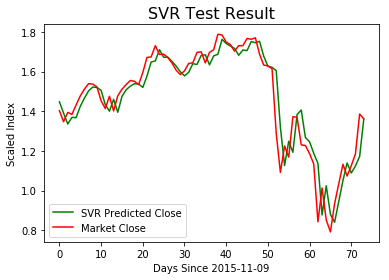

In [161]:
# Plot the prediciton result, and compared to the real values
plt.plot(best_predSVR, color='g',label='SVR Predicted Close')
plt.plot(test_values,color='r',label='Market Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('SVR Test Result', fontsize=16)
plt.show()

In [162]:
# Below is the implementation of FNN

In [163]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

In [164]:
# split into train and test sets
data_FNN = data_SVR
split =int(0.9*len(data_FNN))

X_FNN = data_FNN.drop(['Close'], axis=1)
y_FNN = data_FNN['Close']
X_trainFNN = X_FNN[:split]
y_trainFNN = y_FNN[:split]
X_testFNN = X_FNN[split:]
y_testFNN = y_FNN[split:]
test_valuesFNN = y_testFNN.values


In [165]:
# define the FNN model
def create_model():
    NN_model = Sequential()

# The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_trainFNN.shape[1], activation='relu'))

# The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
    NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return NN_model


In [166]:
# Grid search for the best hyperparameters
param_gridFNN = {'epochs': [50, 100, 500],
             'batch_size': [16, 32, 64]}
modelFNN = KerasRegressor(build_fn=create_model, verbose=0)
scorer_MSE = make_scorer(mean_squared_error, greater_is_better = False)
gridFNN = GridSearchCV(estimator=modelFNN, param_grid=param_gridFNN, scoring = scorer_MSE, cv=TimeSeriesSplit(n_splits=5))
grid_resultFNN = gridFNN.fit(X_trainFNN, y_trainFNN)

In [167]:
# Print the refinement process for each combination of hyperparameters
meansFNN = grid_resultFNN.cv_results_['mean_test_score']
stdsFNN = grid_resultFNN.cv_results_['std_test_score']
paramsFNN = grid_resultFNN.cv_results_['params']
for mean, stdev, param in zip(meansFNN, stdsFNN, paramsFNN):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.028452 (0.023933) with: {'epochs': 50, 'batch_size': 16}
-0.065360 (0.056559) with: {'epochs': 100, 'batch_size': 16}
-0.137892 (0.140789) with: {'epochs': 500, 'batch_size': 16}
-0.035425 (0.031131) with: {'epochs': 50, 'batch_size': 32}
-0.039215 (0.036534) with: {'epochs': 100, 'batch_size': 32}
-0.123257 (0.167969) with: {'epochs': 500, 'batch_size': 32}
-0.025295 (0.014234) with: {'epochs': 50, 'batch_size': 64}
-0.030563 (0.020894) with: {'epochs': 100, 'batch_size': 64}
-0.067902 (0.067321) with: {'epochs': 500, 'batch_size': 64}


In [168]:
# Get the best hyperparameters
print("Best hyperparameter: %.4f using %s" % (grid_resultFNN.best_score_, grid_resultFNN.best_params_))

Best hyperparameter: -0.0253 using {'epochs': 50, 'batch_size': 64}


In [169]:
# Get the best estimator
best_estFNN = gridFNN.best_estimator_

# Make predictions using the best estimator
best_predFNN = best_estFNN.predict(X_testFNN)

#Calcualte the MSE between predicted and real values
MSE_FNN = mean_squared_error(y_testFNN, best_predFNN)
print('Test MSE of FNN algorithm: %.4f' % MSE_FNN)

Test MSE of FNN algorithm: 0.0089


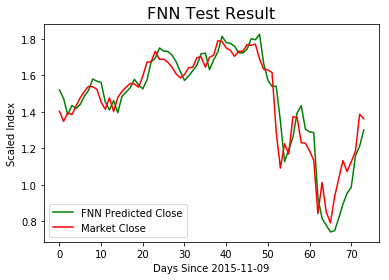

In [170]:
# Plot the results
plt.plot(best_predFNN, color='g',label='FNN Predicted Close')
plt.plot(test_valuesFNN,color='r',label='Market Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('FNN Test Result', fontsize=16)
plt.show()

In [171]:
#Below is the implementation of the XGBoost algorithm

In [172]:
import xgboost as xgb

In [173]:
# Define training and testing data
data_XGB = data_SVR
split =int(0.9*len(data_XGB))

X_XGB = data_XGB.drop(['Close'], axis=1)
y_XGB = data_XGB['Close']
X_trainXGB = X_XGB[:split]
y_trainXGB = y_XGB[:split]
X_testXGB = X_XGB[split:]
y_testXGB = y_XGB[split:]
test_valuesXGB = y_testXGB.values

In [174]:
# Grid search for the best hyperparameters
params_XGB = {'max_depth': [3,5],
'min_child_weight' : [1, 5, 10],
'subsample' : [0.5, 0.8],
'colsample_bytree' : [0.5, 0.8],
'objective' : ['reg:linear'],
'learning_rate' : [0.1, 0.3]
        }

XGBModel = xgb.XGBRegressor(n_estimators=500)
scorer_XGB = make_scorer(mean_squared_error, greater_is_better = False)
grid_XGB = GridSearchCV(XGBModel, params_XGB, verbose=False, scoring = scorer_XGB, cv=TimeSeriesSplit(n_splits=5))
gridXGB_fit = grid_XGB.fit(X_trainXGB, y_trainXGB)

# Print the refinement process for each combination of hyperparameters
meansXGB = gridXGB_fit.cv_results_['mean_test_score']
stdsXGB = gridXGB_fit.cv_results_['std_test_score']
paramsXGB = gridXGB_fit.cv_results_['params']
for mean, stdev, param in zip(meansXGB, stdsXGB, paramsXGB):
    print("%f (%f) with: %r" % (mean, stdev, param))


-0.159496 (0.180515) with: {'colsample_bytree': 0.5, 'subsample': 0.5, 'min_child_weight': 1, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.156401 (0.171817) with: {'colsample_bytree': 0.5, 'subsample': 0.8, 'min_child_weight': 1, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.152689 (0.161145) with: {'colsample_bytree': 0.5, 'subsample': 0.5, 'min_child_weight': 5, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.148960 (0.157562) with: {'colsample_bytree': 0.5, 'subsample': 0.8, 'min_child_weight': 5, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.150478 (0.155014) with: {'colsample_bytree': 0.5, 'subsample': 0.5, 'min_child_weight': 10, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.147065 (0.153065) with: {'colsample_bytree': 0.5, 'subsample': 0.8, 'min_child_weight': 10, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:linear'}
-0.149988 (0.172025) with: {'colsample_bytre

In [175]:
print(grid_XGB.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)


In [176]:
# Get the best estimator
best_estXGB = grid_XGB.best_estimator_

# Make predictions using the best estimator
best_predXGB = best_estXGB.predict(X_testXGB)

# Evalute the predicted results
MSE_XGB = mean_squared_error(y_testXGB, best_predXGB)
print('Test MSE of XGB algorithm: %.4f' % MSE_XGB)

Test MSE of XGB algorithm: 0.0833


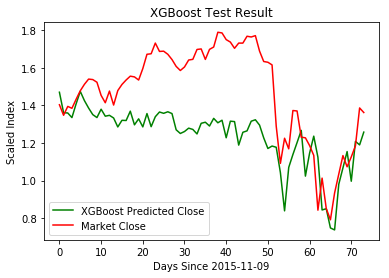

In [177]:
# Plot the results
plt.plot(best_predXGB, color='g',label='XGBoost Predicted Close')
plt.plot(test_valuesXGB,color='r',label='Market Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.title('XGBoost Test Result')
plt.ylabel('Scaled Index')
plt.show()

In [ ]:
# Robust test using NASDAQ index

In [178]:
data_NASDAQ = pd.read_csv("NASDAQ.csv")

In [179]:
# drop the Adj Close
data_new=data_NASDAQ[['Open','High','Low','Close','Volume']]

# Shift the data by 1-day so the prediction is based on the information available 1-day before
data_new['open'] = data_new['Open'].shift(1)
data_new['high']=data_new['High'].shift(1)
data_new['low']=data_new['Low'].shift(1)
data_new['close']=data_new['Close'].shift(1)
data_new['volume']=data_new['Volume'].shift(1)

# n is used as the number of past days to calculation the moving average
n = 10
#RSI is a technicl indicator for momentum
data_new['RSI']=ta.RSI(np.array(data_new['close']), timeperiod=n)
#SMA is a technical indicator for moving average
data_new['SMA']= data_new['close'].rolling(window=n).mean()
#SAR is a trend following indicator
data_new['SAR']=ta.SAR(np.array(data_new['high']),np.array(data_new['low']),0.2,0.2)
#ADX is a technical indicator for trend strength
data_new['ADX']=ta.ADX(np.array(data_new['high']),np.array(data_new['low']),np.array(data_new['close']), timeperiod = 10)

display(data_new.head(n=30))

/Users/yuyuanlin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Open,High,Low,Close,Volume,open,high,low,close,volume,RSI,SMA,SAR,ADX
0,5128.939941,5133.439941,5066.100098,5095.299805,1850770000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5068.549805,5086.879883,5051.220215,5083.240234,1906120000,5128.939941,5133.439941,5066.100098,5095.299805,1.850770e+09,NaN,NaN,NaN,NaN
2,5098.129883,5111.189941,5066.680176,5067.020020,1672340000,5068.549805,5086.879883,5051.220215,5083.240234,1.906120e+09,NaN,NaN,5133.439941,NaN
3,5043.100098,5062.490234,5004.459961,5005.080078,1820930000,5098.129883,5111.189941,5066.680176,5067.020020,1.672340e+09,NaN,NaN,5116.995996,NaN
4,4980.859863,4989.060059,4925.350098,4927.879883,2001050000,5043.100098,5062.490234,5004.459961,5005.080078,1.820930e+09,NaN,NaN,5111.189941,NaN
5,4916.140137,4984.910156,4908.660156,4984.620117,1819190000,4980.859863,4989.060059,4925.350098,4927.879883,2.001050e+09,NaN,NaN,5111.189941,NaN
6,4991.709961,5023.450195,4975.740234,4986.020020,1861710000,4916.140137,4984.910156,4908.660156,4984.620117,1.819190e+09,NaN,NaN,5074.021972,NaN
7,5004.600098,5078.799805,5001.669922,5075.200195,2017390000,4991.709961,5023.450195,4975.740234,4986.020020,1.861710e+09,NaN,NaN,5040.949609,NaN
8,5078.669922,5092.459961,5067.270020,5073.640137,1794110000,5004.600098,5078.799805,5001.669922,5075.200195,2.017390e+09,NaN,NaN,4908.660156,NaN
9,5096.959961,5112.459961,5094.319824,5104.919922,1766630000,5078.669922,5092.459961,5067.270020,5073.640137,1.794110e+09,NaN,NaN,4942.688086,NaN


In [180]:
# drop all the entries with NaN values
data_new = data_new.dropna()
# drop the 'High', 'Low', 'Close' and 'Volume', these data are directly related to the 'Close' index of that day
data_new = data_new.drop(['Open', 'High', 'Low', 'Volume'], axis = 1)
display(data_new.head(n=10))

,Close,open,high,low,close,volume,RSI,SMA,SAR,ADX
20,5098.240234,5139.459961,5139.779785,5082.229980,5101.810059,1.952690e+09,49.492344,5111.876026,5147.000000,11.741476
21,5022.870117,5050.520020,5111.729980,5045.729980,5098.240234,1.871450e+09,49.028015,5111.452051,5147.000000,14.153070
22,5045.169922,5077.209961,5106.370117,5000.120117,5022.870117,2.003450e+09,40.183983,5103.458057,5139.779785,17.323991
23,4933.470215,5026.299805,5075.649902,5019.310059,5045.169922,1.746520e+09,43.532583,5096.361035,5111.847851,20.177820
24,4952.229980,4979.770020,4996.189941,4928.669922,4933.470215,2.084950e+09,33.191226,5076.956055,5106.370117,24.244633
25,4995.359863,4932.609863,4953.600098,4871.589844,4952.229980,2.216060e+09,36.027132,5061.312061,5075.649902,28.540002
26,5071.129883,4991.209961,5026.540039,4986.990234,4995.359863,2.054710e+09,42.285376,5045.217041,5034.837890,29.275440
27,5002.549805,5033.479980,5078.990234,4992.629883,5071.129883,2.036610e+09,51.539248,5040.008008,4871.589844,28.169000
28,4923.080078,5087.169922,5088.580078,5002.549805,5002.549805,1.897220e+09,44.382618,5036.510010,4913.069922,26.868758
29,4968.919922,4982.580078,4996.490234,4921.330078,4923.080078,3.765210e+09,37.651147,5014.591016,5088.580078,27.353472


In [181]:
#scale the values for each training feature
ss1 =StandardScaler()
columns =data_new.columns  
data_new[columns]= ss1.fit_transform(data_new[columns])
data_new=data_new.dropna()
display(data_new.head(10))

,Close,open,high,low,close,volume,RSI,SMA,SAR,ADX
20,-0.987564,-0.944478,-0.966822,-0.973518,-0.981578,-0.096921,-0.543307,-0.962753,-0.917396,-1.549039
21,-1.058052,-1.027577,-0.992891,-1.007855,-0.984917,-0.303383,-0.577211,-0.963151,-0.917396,-1.294742
22,-1.037197,-1.002640,-0.997872,-1.050762,-1.055424,0.032080,-1.222980,-0.970658,-0.924167,-0.960376
23,-1.141661,-1.050207,-1.026423,-1.032710,-1.034563,-0.620878,-0.978474,-0.977323,-0.950364,-0.659447
24,-1.124117,-1.093680,-1.100270,-1.117978,-1.139057,0.239203,-1.733574,-0.995547,-0.955502,-0.230612
25,-1.083780,-1.137743,-1.139852,-1.171676,-1.121507,0.572404,-1.526503,-1.010239,-0.984314,0.222324
26,-1.012919,-1.082992,-1.072064,-1.063114,-1.081160,0.162351,-1.069542,-1.025354,-1.022591,0.299874
27,-1.077056,-1.043498,-1.023318,-1.057809,-1.010278,0.116352,-0.393847,-1.030246,-1.175698,0.183202
28,-1.151378,-0.993334,-1.014406,-1.048477,-1.074434,-0.237891,-0.916406,-1.033531,-1.136794,0.046095
29,-1.108508,-1.091055,-1.099991,-1.124883,-1.148776,4.509388,-1.407922,-1.054116,-0.972187,0.097207


In [182]:
#Split data for testing robustness
split =int(0.9*len(data_new))
X_new = data_new.drop(['Close'], axis=1)
y_new = data_new['Close']
X_test_new = X_new[split:]
y_test_new = y_new[split:]
test_values_new = y_test_new.values

In [202]:
best_pred_SVRnew = best_estSVR.predict(X_test_new)
MSE_SVR_new = mean_squared_error(y_test_new, best_pred_SVRnew)
print('Test MSE of SVR algorithm: %.4f' % MSE_SVR_new)

Test MSE of SVR algorithm: 0.0077


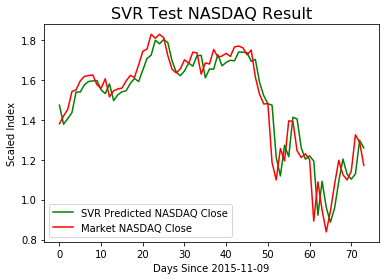

In [194]:
# Plot the prediciton result, and compared to the real values
plt.plot(best_pred_SVRnew, color='g',label='SVR Predicted NASDAQ Close')
plt.plot(test_values_new,color='r',label='Market NASDAQ Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('SVR Test NASDAQ Result', fontsize=16)
plt.show()

In [187]:
# Get the best estimator
best_est_FNN = gridFNN.best_estimator_

# Make predictions using the best estimator
best_pred_FNNnew = best_est_FNN.predict(X_test_new)

#Calcualte the MSE between predicted and real values
MSE_FNN_new = mean_squared_error(y_test_new, best_pred_FNNnew)
print('Test MSE of FNN algorithm: %.4f' % MSE_FNN_new)

Test MSE of FNN algorithm: 0.0113


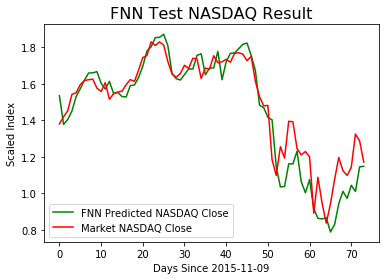

In [195]:
plt.plot(best_pred_FNNnew, color='g',label='FNN Predicted NASDAQ Close')
plt.plot(test_values_new,color='r',label='Market NASDAQ Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('FNN Test NASDAQ Result', fontsize=16)
plt.show()

In [189]:
# Get the best estimator
best_est_XGBnew = grid_XGB.best_estimator_

# Make predictions using the best estimator
best_pred_XGBnew = best_est_XGBnew.predict(X_test_new)

# Evalute the predicted results
MSE_XGB_new = mean_squared_error(y_testXGB, best_pred_XGBnew)
print('Test MSE of XGB algorithm: %.4f' % MSE_XGB_new)

Test MSE of XGB algorithm: 0.1391


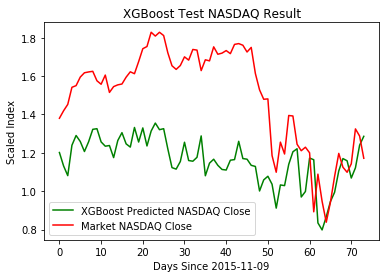

In [196]:
# Plot the results
plt.plot(best_pred_XGBnew, color='g',label='XGBoost Predicted NASDAQ Close')
plt.plot(test_values_new,color='r',label='Market NASDAQ Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.title('XGBoost Test NASDAQ Result')
plt.ylabel('Scaled Index')
plt.show()

In [197]:
# Robust test using Dow Jones Index

In [198]:
data_Dow = pd.read_csv("Dow.csv")
# drop the Adj Close
data_new2=data_Dow[['Open','High','Low','Close','Volume']]

# Shift the data by 1-day so the prediction is based on the information available 1-day before
data_new2['open'] = data_new2['Open'].shift(1)
data_new2['high']=data_new2['High'].shift(1)
data_new2['low']=data_new2['Low'].shift(1)
data_new2['close']=data_new2['Close'].shift(1)
data_new2['volume']=data_new2['Volume'].shift(1)

# n is used as the number of past days to calculation the moving average
n = 10
#RSI is a technicl indicator for momentum
data_new2['RSI']=ta.RSI(np.array(data_new2['close']), timeperiod=n)
#SMA is a technical indicator for moving average
data_new2['SMA']= data_new2['close'].rolling(window=n).mean()
#SAR is a trend following indicator
data_new2['SAR']=ta.SAR(np.array(data_new2['high']),np.array(data_new2['low']),0.2,0.2)
#ADX is a technical indicator for trend strength
data_new2['ADX']=ta.ADX(np.array(data_new2['high']),np.array(data_new2['low']),np.array(data_new2['close']), timeperiod = 10)

display(data_new2.head(n=30))

/Users/yuyuanlin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Open,High,Low,Close,Volume,open,high,low,close,volume,RSI,SMA,SAR,ADX
0,17900.779297,17900.779297,17667.779297,17730.480469,121210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17724.130859,17768.660156,17657.720703,17758.210938,108640000,17900.779297,17900.779297,17667.779297,17730.480469,121210000.0,NaN,NaN,NaN,NaN
2,17769.500000,17807.179688,17696.910156,17702.220703,95230000,17724.130859,17768.660156,17657.720703,17758.210938,108640000.0,NaN,NaN,17900.779297,NaN
3,17691.929688,17691.929688,17443.500000,17448.070313,113660000,17769.500000,17807.179688,17696.910156,17702.220703,95230000.0,NaN,NaN,17852.167578,NaN
4,17439.250000,17439.250000,17238.890625,17245.240234,134640000,17691.929688,17691.929688,17443.500000,17448.070313,113660000.0,NaN,NaN,17813.278203,NaN
5,17229.939453,17483.009766,17210.429688,17483.009766,137590000,17439.250000,17439.250000,17238.890625,17245.240234,134640000.0,NaN,NaN,17807.179688,NaN
6,17486.990234,17599.330078,17451.410156,17489.500000,167190000,17229.939453,17483.009766,17210.429688,17483.009766,137590000.0,NaN,NaN,17693.521875,NaN
7,17485.490234,17752.160156,17485.490234,17737.160156,106810000,17486.990234,17599.330078,17451.410156,17489.500000,167190000.0,NaN,NaN,17210.429688,NaN
8,17739.830078,17772.970703,17681.980469,17732.750000,114630000,17485.490234,17752.160156,17485.490234,17737.160156,106810000.0,NaN,NaN,17210.429688,NaN
9,17732.750000,17914.339844,17732.750000,17823.810547,153140000,17739.830078,17772.970703,17681.980469,17732.750000,114630000.0,NaN,NaN,17318.775782,NaN


In [199]:
# drop all the entries with NaN values
data_new2 = data_new2.dropna()
# drop the 'High', 'Low', 'Close' and 'Volume', these data are directly related to the 'Close' index of that day
data_new2 = data_new2.drop(['Open', 'High', 'Low', 'Volume'], axis = 1)
display(data_new2.head(n=10))

,Close,open,high,low,close,volume,RSI,SMA,SAR,ADX
20,17568.000000,17845.490234,17845.490234,17639.250000,17730.509766,99670000.0,49.441356,17762.541016,17866.470703,13.118608
21,17492.300781,17703.990234,17703.990234,17485.390625,17568.000000,113720000.0,43.770363,17740.073047,17866.470703,15.543464
22,17574.750000,17558.179688,17767.689453,17403.509766,17492.300781,122020000.0,41.317506,17708.084180,17845.490234,18.333563
23,17265.210938,17493.169922,17697.740234,17474.660156,17574.750000,107310000.0,45.044478,17684.220117,17767.689453,20.844652
24,17368.500000,17574.750000,17574.750000,17230.500000,17265.210938,134510000.0,35.610206,17629.402149,17767.689453,24.593121
25,17524.910156,17277.109375,17378.019531,17138.470703,17368.500000,142540000.0,40.250024,17594.260156,17697.740234,28.380454
26,17749.089844,17374.779297,17627.630859,17341.179688,17524.910156,123430000.0,46.710886,17557.916211,17138.470703,28.047510
27,17495.839844,17530.849609,17784.359375,17483.679688,17749.089844,123790000.0,54.539360,17559.857227,17138.470703,26.016817
28,17128.550781,17756.539063,17796.759766,17493.500000,17495.839844,115780000.0,46.048284,17561.674219,17267.648437,24.059657
29,17251.619141,17495.039063,17496.580078,17124.310547,17128.550781,344560000.0,36.812665,17489.766211,17796.759766,24.960334


In [200]:
#scale the values for each training feature
ss1 =StandardScaler()
columns =data_new2.columns  
data_new2[columns]= ss1.fit_transform(data_new2[columns])
data_new2=data_new2.dropna()
display(data_new2.head(10))

,Close,open,high,low,close,volume,RSI,SMA,SAR,ADX
20,-1.212637,-1.118824,-1.141889,-1.160131,-1.157697,-1.150157,-0.590656,-1.136796,-1.090766,-1.180051
21,-1.236876,-1.164122,-1.186959,-1.209619,-1.209762,-1.044708,-0.968882,-1.144025,-1.090766,-1.006739
22,-1.210476,-1.210799,-1.166669,-1.235956,-1.234015,-0.982415,-1.132475,-1.154318,-1.097481,-0.807322
23,-1.309589,-1.231610,-1.188949,-1.213071,-1.207600,-1.092817,-0.883905,-1.161996,-1.122383,-0.627847
24,-1.276516,-1.205494,-1.228123,-1.291603,-1.306771,-0.888674,-1.513122,-1.179634,-1.122383,-0.359933
25,-1.226434,-1.300776,-1.290785,-1.321204,-1.273679,-0.828407,-1.203671,-1.190941,-1.144772,-0.089240
26,-1.154653,-1.269509,-1.211280,-1.256004,-1.223568,-0.971832,-0.772765,-1.202634,-1.323780,-0.113037
27,-1.235742,-1.219548,-1.161360,-1.210170,-1.151744,-0.969130,-0.250646,-1.202010,-1.323780,-0.258177
28,-1.353347,-1.147300,-1.157410,-1.207011,-1.232881,-1.029248,-0.816957,-1.201425,-1.282433,-0.398061
29,-1.313941,-1.231012,-1.253022,-1.325758,-1.350555,0.687807,-1.432925,-1.224562,-1.113079,-0.333687


In [201]:
#Split data for testing robustness
split =int(0.9*len(data_new2))
X_new2 = data_new2.drop(['Close'], axis=1)
y_new2 = data_new2['Close']
X_test_new2 = X_new2[split:]
y_test_new2 = y_new2[split:]
test_values_new2 = y_test_new2.values

In [204]:
best_pred_SVRnew2 = best_estSVR.predict(X_test_new2)
MSE_SVR_new2 = mean_squared_error(y_test_new2, best_pred_SVRnew2)
print('Test MSE of SVR algorithm: %.4f' % MSE_SVR_new2)

Test MSE of SVR algorithm: 0.0054


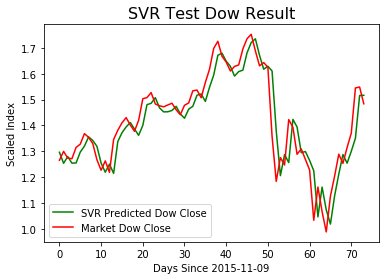

In [206]:
# Plot the prediciton result, and compared to the real values
plt.plot(best_pred_SVRnew2, color='g',label='SVR Predicted Dow Close')
plt.plot(test_values_new2,color='r',label='Market Dow Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('SVR Test Dow Result', fontsize=16)
plt.show()

In [207]:
# Get the best estimator
best_est_FNN2 = gridFNN.best_estimator_

# Make predictions using the best estimator
best_pred_FNNnew2 = best_est_FNN2.predict(X_test_new2)

#Calcualte the MSE between predicted and real values
MSE_FNN_new2 = mean_squared_error(y_test_new2, best_pred_FNNnew2)
print('Test MSE of FNN algorithm: %.4f' % MSE_FNN_new2)

Test MSE of FNN algorithm: 0.0103


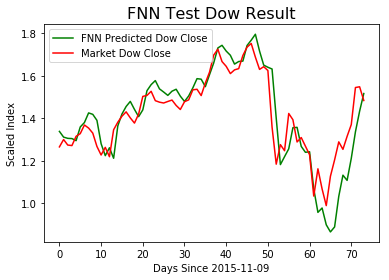

In [211]:
plt.plot(best_pred_FNNnew2, color='g',label='FNN Predicted Dow Close')
plt.plot(test_values_new2,color='r',label='Market Dow Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.ylabel('Scaled Index')
plt.title('FNN Test Dow Result', fontsize=16)
plt.show()

In [212]:
# Get the best estimator
best_est_XGBnew2 = grid_XGB.best_estimator_

# Make predictions using the best estimator
best_pred_XGBnew2 = best_est_XGBnew2.predict(X_test_new2)

# Evalute the predicted results
MSE_XGB_new2 = mean_squared_error(y_test_new2, best_pred_XGBnew2)
print('Test MSE of XGB algorithm: %.4f' % MSE_XGB_new2)

Test MSE of XGB algorithm: 0.0451


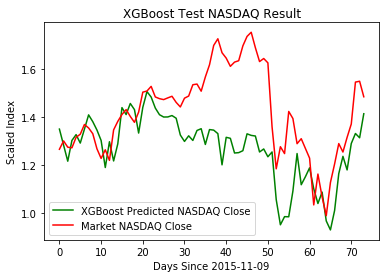

In [213]:
# Plot the results
plt.plot(best_pred_XGBnew2, color='g',label='XGBoost Predicted NASDAQ Close')
plt.plot(test_values_new2,color='r',label='Market NASDAQ Close')
plt.legend(loc='best')
plt.xlabel('Days Since 2015-11-09')
plt.title('XGBoost Test NASDAQ Result')
plt.ylabel('Scaled Index')
plt.show()